# Score LCL dsQTL variants

In this notebook, we score LCL dsQTLs with the trained GM12878 DNase regression model.

In [2]:
# ! pip install git+https://github.com/Genentech/gReLU

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set experiment parameters

In [3]:
import grelu
grelu.__version__

'1.0.5.post1.dev13'

In [4]:
import grelu.lightning
import grelu.resources

/home/nairs51/miniforge3/envs/grelu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = grelu.resources.load_model(project="GM12878_dnase", model_name='model', host="https://api.wandb.ai")

wandb: Currently logged in as: anony-mouse-444847806635717680 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  


## Variants

In [6]:
# file can be downloaded from https://static-content.springer.com/esm/art%3A10.1038%2Fng.3331/MediaObjects/41588_2015_BFng3331_MOESM26_ESM.xlsx
variants_df = pd.read_csv("/home/nairs51/resources/LCL_dsQTL/41588_2015_BFng3331_MOESM26_ESM.tsv", sep='\t')
variants_df = variants_df[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'label', 'abs_gkm_SVM']]
variants_df = variants_df.set_axis(['chrom', 'pos', 'ref', 'alt', 'label', 'abs_gkm_SVM'], axis=1)
variants_df['label'] = variants_df['label'].replace(-1, 0)

variants_df['start'] = variants_df['pos']
variants_df['end'] = variants_df['start'] + 1

variants_df.head()

,chrom,pos,ref,alt,label,abs_gkm_SVM,start,end
0,chr1,856583,A,G,1,2.653531,856583,856584
1,chr1,911595,G,A,1,2.821422,911595,911596
2,chr1,1186502,T,A,1,7.167236,1186502,1186503
3,chr1,1227412,A,G,1,3.957382,1227412,1227413
4,chr1,1590575,A,G,1,4.785596,1590575,1590576


In [7]:
from grelu.data.preprocess import filter_blacklist, filter_chromosomes, filter_chrom_ends
from grelu.variant import filter_variants

In [8]:
variants = filter_variants(variants_df, max_del_len=0, max_insert_len=0, standard_bases=True)

Initial number of variants: 28309
Final number of variants: 28309


In [9]:
variants = filter_chromosomes(variants, include='autosomesXY')

Keeping 28309 intervals


In [10]:
ENFORMER_SEQLEN = 196608

In [11]:
variants = filter_chrom_ends(variants, genome='hg19', pad=ENFORMER_SEQLEN//2)

Keeping 28274 intervals


## Predict

In [12]:
import grelu.variant

odds = grelu.variant.predict_variant_effects(
    variants=variants,
    model=model, 
    devices=0, # Run on GPU 0
    num_workers=8,
    batch_size=128,
    genome="hg19",
    compare_func="subtract", 
    return_ad=True, # Return an anndata object.
    rc = True, # Reverse complement the ref/alt predictions and average them.
)

making dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nairs51/miniforge3/envs/grelu/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [01:42<00:00,  8.60it/s]


/home/nairs51/miniforge3/envs/grelu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
import sklearn.metrics

In [14]:
auprc = sklearn.metrics.average_precision_score(variants['label'], np.abs(odds.X.ravel()))
auprc

0.27340074797516273

In [15]:
pr, rec, _ = sklearn.metrics.precision_recall_curve(variants['label'], np.abs(odds.X.ravel()))

### Plot

In [21]:
variants_df = variants.reset_index(drop=True)
variants_df.shape

(28274, 8)

In [22]:
prsvm, recsvm, _ = sklearn.metrics.precision_recall_curve(variants_df['label'], variants_df['abs_gkm_SVM'])

In [23]:
prrd, recrd, _ = sklearn.metrics.precision_recall_curve(variants_df['label'], variants_df['abs_gkm_SVM'][np.random.permutation(len(variants_df))])

In [24]:
gkm_auprc = sklearn.metrics.average_precision_score(variants_df['label'], variants_df['abs_gkm_SVM'])

In [25]:
random_auprc = sklearn.metrics.average_precision_score(variants_df['label'], variants_df['abs_gkm_SVM'][np.random.permutation(len(variants_df))])

In [26]:
# enformer computed scores (see `2_variants_Enformer.ipynb`)
enformer_preds = pd.read_csv("./out/enformer_dsQTL.tsv", sep='\t')
enformer_preds.head(2)

,chrom,pos,ref,alt,label,abs_gkm_SVM,start,end,enformer_task_12_ENCFF093VXI_LFC_rc
0,chr1,856583,A,G,1,2.653531,856583,856584,-0.200571
1,chr1,911595,G,A,1,2.821422,911595,911596,0.307417


In [27]:
len(enformer_preds) == len(variants_df)

True

In [28]:
enf_auprc = sklearn.metrics.average_precision_score(variants_df['label'], np.abs(enformer_preds['enformer_task_12_ENCFF093VXI_LFC_rc']))

In [29]:
prenf, recenf, _ = sklearn.metrics.precision_recall_curve(variants_df['label'], np.abs(enformer_preds['enformer_task_12_ENCFF093VXI_LFC_rc']))

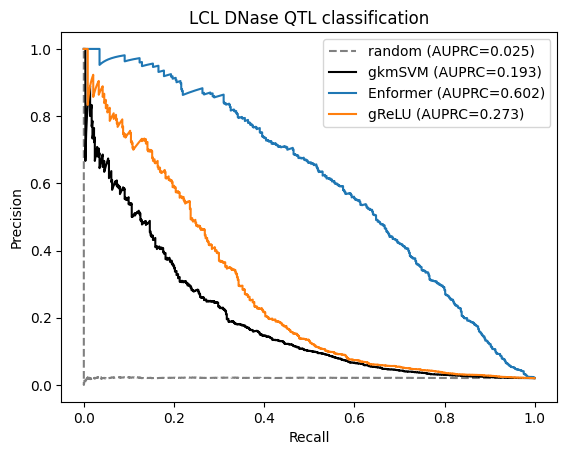

In [32]:
plt.plot(recrd, prrd, label='random (AUPRC={})'.format(round(random_auprc,3)), c='gray', linestyle='--')
plt.plot(recsvm, prsvm, 'k', label='gkmSVM (AUPRC={})'.format(round(gkm_auprc,3)))
plt.plot(recenf, prenf, label='Enformer (AUPRC={})'.format(round(enf_auprc,3)))
plt.plot(rec, pr, label='gReLU (AUPRC={})'.format(round(auprc, 3)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("LCL DNase QTL classification")

# plt.savefig("figures/AUPRC.pdf", dpi=300)

## Examples

In [12]:
from grelu.transforms.prediction_transforms import Aggregate
lcl_score = Aggregate(tasks=[0], model=model)

In [34]:
np.argsort(np.abs(odds.X.ravel()[:573]))[::-1][:50]

array([191, 352,  67, 170,  25, 456, 379,   9, 304, 283, 396, 194, 263,
        95,  79,  41, 226, 242, 523, 359, 436, 498, 521, 284, 433, 127,
       524, 189, 556, 230, 330, 218, 422,  65, 490, 123, 355, 569, 325,
       467, 358, 424, 231, 302,  10,  68,  35, 495, 106, 337])

In [35]:
VARIANT_IDX = 337
variant = variants.iloc[VARIANT_IDX] 

In [36]:
variant

chrom               chr2
pos            216696316
ref                    G
alt                    A
label                  1
abs_gkm_SVM     6.607731
start          216696316
end            216696317
Name: 337, dtype: object

In [37]:
ref_seq, alt_seq = grelu.variant.variant_to_seqs(
    seq_len=model.data_params['train']['seq_len'],
    genome='hg19',
    **variant[["chrom", "pos", "ref", "alt"]]
)

In [38]:
SEQLEN = 2114

In [39]:
import grelu.interpret.score

ref_attrs = grelu.interpret.score.get_attributions(
    model, ref_seq, prediction_transform=lcl_score, device=0,
    seed=0, method="saliency", correct_grad=True
)

alt_attrs = grelu.interpret.score.get_attributions(
    model, alt_seq, prediction_transform=lcl_score, device=0,
    seed=0, method="saliency", correct_grad=True
)

/home/nairs51/miniforge3/envs/grelu/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [40]:
ref_seq_ohe = grelu.sequence.format.strings_to_one_hot([ref_seq]).numpy()
alt_seq_ohe = grelu.sequence.format.strings_to_one_hot([alt_seq]).numpy()

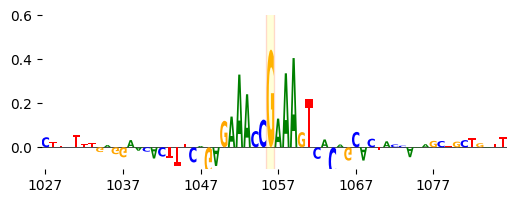

In [41]:
import grelu.visualize
grelu.visualize.plot_attributions(
    ref_attrs*ref_seq_ohe, start_pos=SEQLEN//2-30, end_pos=SEQLEN//2+30,
    highlight_positions=[SEQLEN//2-1], ticks=10,
    edgecolor='red', 
    figsize=(6,2),
)
plt.ylim(-0.1,0.6)
plt.savefig("figures/ref.pdf")

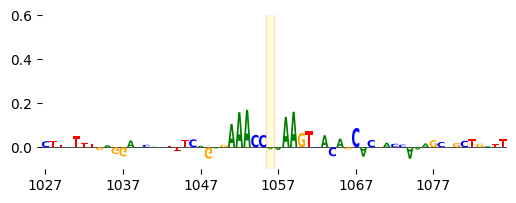

In [42]:
grelu.visualize.plot_attributions(
    alt_attrs*alt_seq_ohe, start_pos=SEQLEN//2-30, end_pos=SEQLEN//2+30,
    highlight_positions=[SEQLEN//2-1], ticks=10,
    edgecolor='red',
    figsize=(6,2)
)
plt.ylim(-0.1,0.6)
plt.savefig("figures/alt.pdf")

## TF-MoDISco on all variants

Perform TF-MoDISco on all variants to see if motifs are preferentially enriched around dsQTLs (as per the model).

In [13]:
warnings.filterwarnings('ignore') 

all_ref_seqs = []
all_alt_seqs = []

for i in tqdm(range(len(variants))):
    ref_seq, alt_seq = grelu.variant.variant_to_seqs(
            seq_len=model.data_params['train']['seq_len'],
            genome='hg19',
            **variants.iloc[i][["chrom", "pos", "ref", "alt"]]
        )
    all_ref_seqs.append(ref_seq)
    all_alt_seqs.append(alt_seq)

warnings.filterwarnings('default')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28274/28274 [01:33<00:00, 302.53it/s]


In [14]:
len(all_ref_seqs), len(all_alt_seqs)

(28274, 28274)

In [15]:
interleaved_seqs = []

for i in range(len(all_ref_seqs)):
    interleaved_seqs.append(all_ref_seqs[i])
    interleaved_seqs.append(all_alt_seqs[i])

In [16]:
len(interleaved_seqs)

56548

In [17]:
import grelu.interpret.modisco

In [19]:
warnings.filterwarnings('ignore') 

grelu.interpret.modisco.run_modisco(model,
                                    interleaved_seqs,
                                    prediction_transform=lcl_score,
                                    window=100,
                                    devices=4,
                                    meme_file="./resources/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme",
                                    method='saliency',
                                    correct_grad=True,
                                   out_dir="./modisco/",
                                   max_seqlets_per_metacluster=1000000 # ensures all seqlets are considered
                                   )

warnings.filterwarnings('default')

Getting attributions
Running modisco
Writing modisco output
Creating sequence logos
Creating html report
Running TOMTOM
